In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing

trainRaw = pd.read_csv("train.csv")
evalRaw = pd.read_csv("test.csv")

 # trainRaw.head(1)

In [2]:
from sklearn.model_selection import train_test_split

def normalizer(data): #scale values like the cost of a ticket to create more stable predictions
    
    x_normal = preprocessing.MinMaxScaler().fit_transform(data.values)
    
    return pd.DataFrame(x_normal, columns=data.columns)

def clean(data): #drops irrelevant info, converts categorical values to numerical, fills NaN, calls normalizer
    
    data = data.drop(["PassengerId", "Name", "Ticket", "Cabin"], axis=1)
    data = pd.get_dummies(data, columns=["Sex", "Embarked"])
    
    
    data.fillna(data.mean(), inplace=True)
    
    if 'Survived' in data.columns:
        data_x = normalizer(data.drop(["Survived"], axis=1))
        data_y = data["Survived"]
        return data_x, data_y
    else:
        return normalizer(data)

t_x, t_y = clean(trainRaw)
eval_x = clean(evalRaw)

trn_X, tst_X, trn_y, tst_y = train_test_split(t_x, t_y, test_size = 0.2) #splits data into train(80%) and test(20%)

train_X = torch.Tensor(trn_X.to_numpy())
train_y = torch.Tensor(trn_y.to_numpy()) #.type(torch.LongTensor)
test_X = torch.Tensor(tst_X.to_numpy())
test_y = torch.Tensor(tst_y.to_numpy()) #.type(torch.LongTensor)

eval_X = torch.Tensor(eval_x.to_numpy())

 # print(t_x.head(1))
 # print(train_X[1])

In [3]:
import torch.nn as nn
import torch.nn.functional as F

class Network(torch.nn.Module):

    def __init__(self):
        super(Network, self).__init__()
        
        self.lay1 = nn.Linear(10, 20)
        self.lay2 = nn.Linear(20, 1)

    def forward(self, x):
        x = self.lay1(x)
        x = F.relu(x) 
        x = F.dropout(x, p=0.1)
        x = self.lay2(x)
        x = torch.sigmoid(x)
        
        return x
    
model = Network()

 # print(model)
 # len(model(train_X))

In [4]:
from sklearn.utils import shuffle
from torch.autograd import Variable

    
optimizer = torch.optim.SGD(model.parameters(), lr = 0.5, momentum = 0.7)
loss_fn = nn.BCELoss()

def accuracy_fn(y_true, y_prediction):
    correct = torch.eq(y_true, y_prediction).sum().item()
    acc = (correct / len(y_prediction)) * 100
    return acc
    
    
epochs = 60

train_X, train_y = shuffle(train_X, train_y)

epochs = 60

for e in range(epochs):
    optimizer.zero_grad()
    y_pred_raw = model(train_X).squeeze()
    y_pred = torch.round((y_pred_raw))
    loss = loss_fn(y_pred_raw, train_y)
    loss.backward()
    optimizer.step()
    acc = accuracy_fn(train_y, y_pred)

    model.eval()
    with torch.no_grad():
        y_test_raw = model(test_X).squeeze()
        y_test = torch.round(y_test_raw)
        test_loss = loss_fn(y_test_raw, test_y)
        test_acc = accuracy_fn(test_y, y_test)
        
    model.train()
    
    if e % 10 == 0:
        print(f"Epoch: {e} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")
        #print(f"Epoch: {e} | Raw Prediction: {y_pred_raw} | Transform: {y_pred} | Actual: {train_y}")

Epoch: 0 | Loss: 0.68541, Accuracy: 60.67% | Test loss: 0.65620, Test acc: 63.69%
Epoch: 10 | Loss: 0.50440, Accuracy: 79.35% | Test loss: 0.54394, Test acc: 74.30%
Epoch: 20 | Loss: 0.45572, Accuracy: 78.79% | Test loss: 0.52123, Test acc: 73.74%
Epoch: 30 | Loss: 0.44524, Accuracy: 78.65% | Test loss: 0.51284, Test acc: 75.98%
Epoch: 40 | Loss: 0.44549, Accuracy: 79.35% | Test loss: 0.51114, Test acc: 78.77%
Epoch: 50 | Loss: 0.43693, Accuracy: 80.06% | Test loss: 0.52005, Test acc: 75.42%


In [6]:
with torch.no_grad():
    results_raw = model(eval_X).squeeze()
    results = torch.round(results_raw)
    
 # print(results.size())

In [7]:
print(results)
int_results = results.int()
print(int_results)

submission = pd.DataFrame({"PassengerID" : evalRaw["PassengerId"], 
                           "Survived" : int_results})

submission.head()
submission.describe()

tensor([0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 1., 1., 0., 0.,
        0., 1., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0.,
        1., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 1., 1.,
        0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 1., 1., 0., 1., 1., 1., 0.,
        0., 1., 1., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0.,
        1., 0., 1., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 1., 1., 0., 1., 0., 0., 1.,
        0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,
        0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 1., 1., 0.,
        1., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 1., 0., 1., 1.,
        0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0., 1., 1., 0., 1., 1., 0., 1., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0.,
        1., 0., 1., 0., 1., 0., 1., 0., 

,PassengerID,Survived
count,418.000000,418.000000
mean,1100.500000,0.354067
std,120.810458,0.478803
min,892.000000,0.000000
25%,996.250000,0.000000
50%,1100.500000,0.000000
75%,1204.750000,1.000000
max,1309.000000,1.000000


In [ ]:
#submission.to_csv('titanicML_submission6.csv', index=False)

In [34]:
import shap

np_train_X = train_X.numpy()
np_test_X = test_X.numpy()

def model_convert(data_as_array):
    data_as_tensor = torch.from_numpy(data_as_array).float()
    with torch.no_grad():
        model_output = model(data_as_tensor)
        model_output = torch.round(model_output)
    return model_output.numpy()

explainer = shap.Explainer(model_convert, np_train_X)

shap_values = explainer(np_test_X)

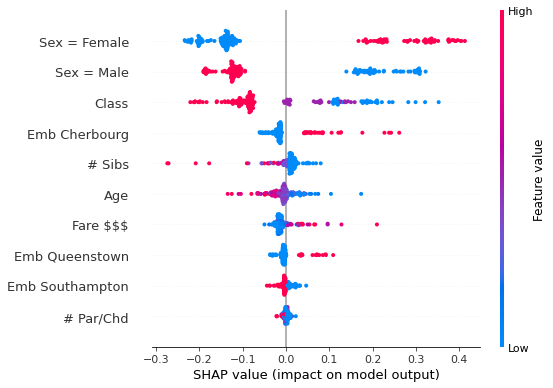

In [35]:
shap.summary_plot(shap_values, np_test_X, feature_names=["Class", "Age", "# Sibs", "# Par/Chd", "Fare $$$", "Sex = Female", "Sex = Male", "Emb Cherbourg", "Emb Queenstown", "Emb Southampton"])

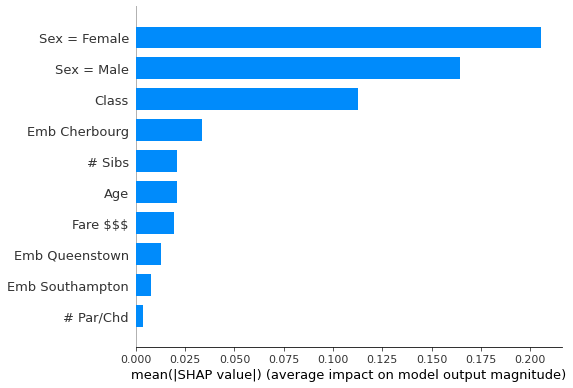

In [36]:
shap.summary_plot(shap_values, plot_type = "bar", feature_names=["Class", "Age", "# Sibs", "# Par/Chd", "Fare $$$", "Sex = Female", "Sex = Male", "Emb Cherbourg", "Emb Queenstown", "Emb Southampton"])

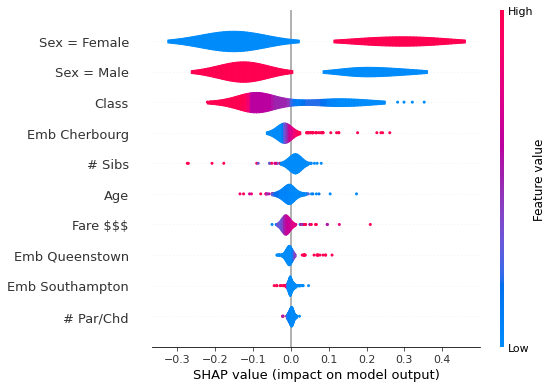

In [37]:
shap.summary_plot(shap_values, plot_type = "violin", feature_names=["Class", "Age", "# Sibs", "# Par/Chd", "Fare $$$", "Sex = Female", "Sex = Male", "Emb Cherbourg", "Emb Queenstown", "Emb Southampton"])

In [44]:
 # shap.plots.bar(shap_values.base_values)
print(shap_values.values[0])

[-0.1337381   0.01174603  0.01308333  0.00335714 -0.0164127  -0.14903968
 -0.1415754   0.04577381 -0.00771825  0.00452381]


In [57]:
shap_values_array = np.array(shap_values.values)
sexf_shap_values = shap_values_array[:, 5]
sexf_shapVal = np.mean(np.abs(sexf_shap_values))
print("Average absolute SHAP value for Pclass:", sexf_shapVal)

Average absolute SHAP value for Pclass: 0.20574104371730045
